In [49]:
from pathlib import Path
import re

import math
import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

sns.set_theme(style="whitegrid", font_scale=1, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [59]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]


def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))

    bars = []
    labels = []
    hue = []
    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=200).mean()
        *model, dist = label.split(" ")
        data.append({
            'reward': reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette="Set2",
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(36, 107, 60), (220, 95, 46), (0, 122, 184)]
    for i, bar in enumerate(ax.patches):
        if i % n_models == 0 and len(baseline_rgb):
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb.pop(0)), orig[3]))

        elif i % n_models > 3:
            bar.set_hatch('..')

    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 200 episodes and 3 seeds in ManiSkill")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))

    bars = []
    labels = []
    hue = []
    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=50, min_length=21).mean()
        *model, dist = label.split(" ")
        data.append({
            'reward': reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    my_palette = {
        "In-Distribution":   "#4AAD53",   # a green
        "Weak": "#6699CC",   # an orange
        "Strong": "#FF3C1C"    # a blue
    }

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette=my_palette,
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(126, 200, 133),(133, 173, 214),(255, 155, 153)]
    for i, bar in enumerate(ax.patches):
        j = math.floor(i / n_models)
        if j >= len(baseline_rgb):
            continue

        if i % n_models == 0:
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb[j]), orig[3]))

        else:
            if i % n_models > 3:
                bar.set_hatch('..')


    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 50 episodes and 3 seeds in CARLA")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

[{'reward': 10.91115521316242, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.589080814711046, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.808499995227011, 'model': 'Baseline', 'Evaluation Distribution': 'ID'}, {'reward': 10.548903430586797, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 10.616755346807185, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 10.913860513672699, 'model': 'Baseline', 'Evaluation Distribution': 'OOD'}, {'reward': 0.10701059997718403, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 0.14747184826872398, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 0.1255285521348469, 'model': 'Baseline', 'Evaluation Distribution': 'Texture'}, {'reward': 10.886660591497861, 'model': 'DINO Finetune', 'Evaluation Distribution': 'ID'}, {'reward': 10.052148400038714, 'model': 'DINO Finetune', 'Evaluation Distribution': 'ID'}, {'reward': 9.75750624808

<Figure size 6000x1800 with 0 Axes>

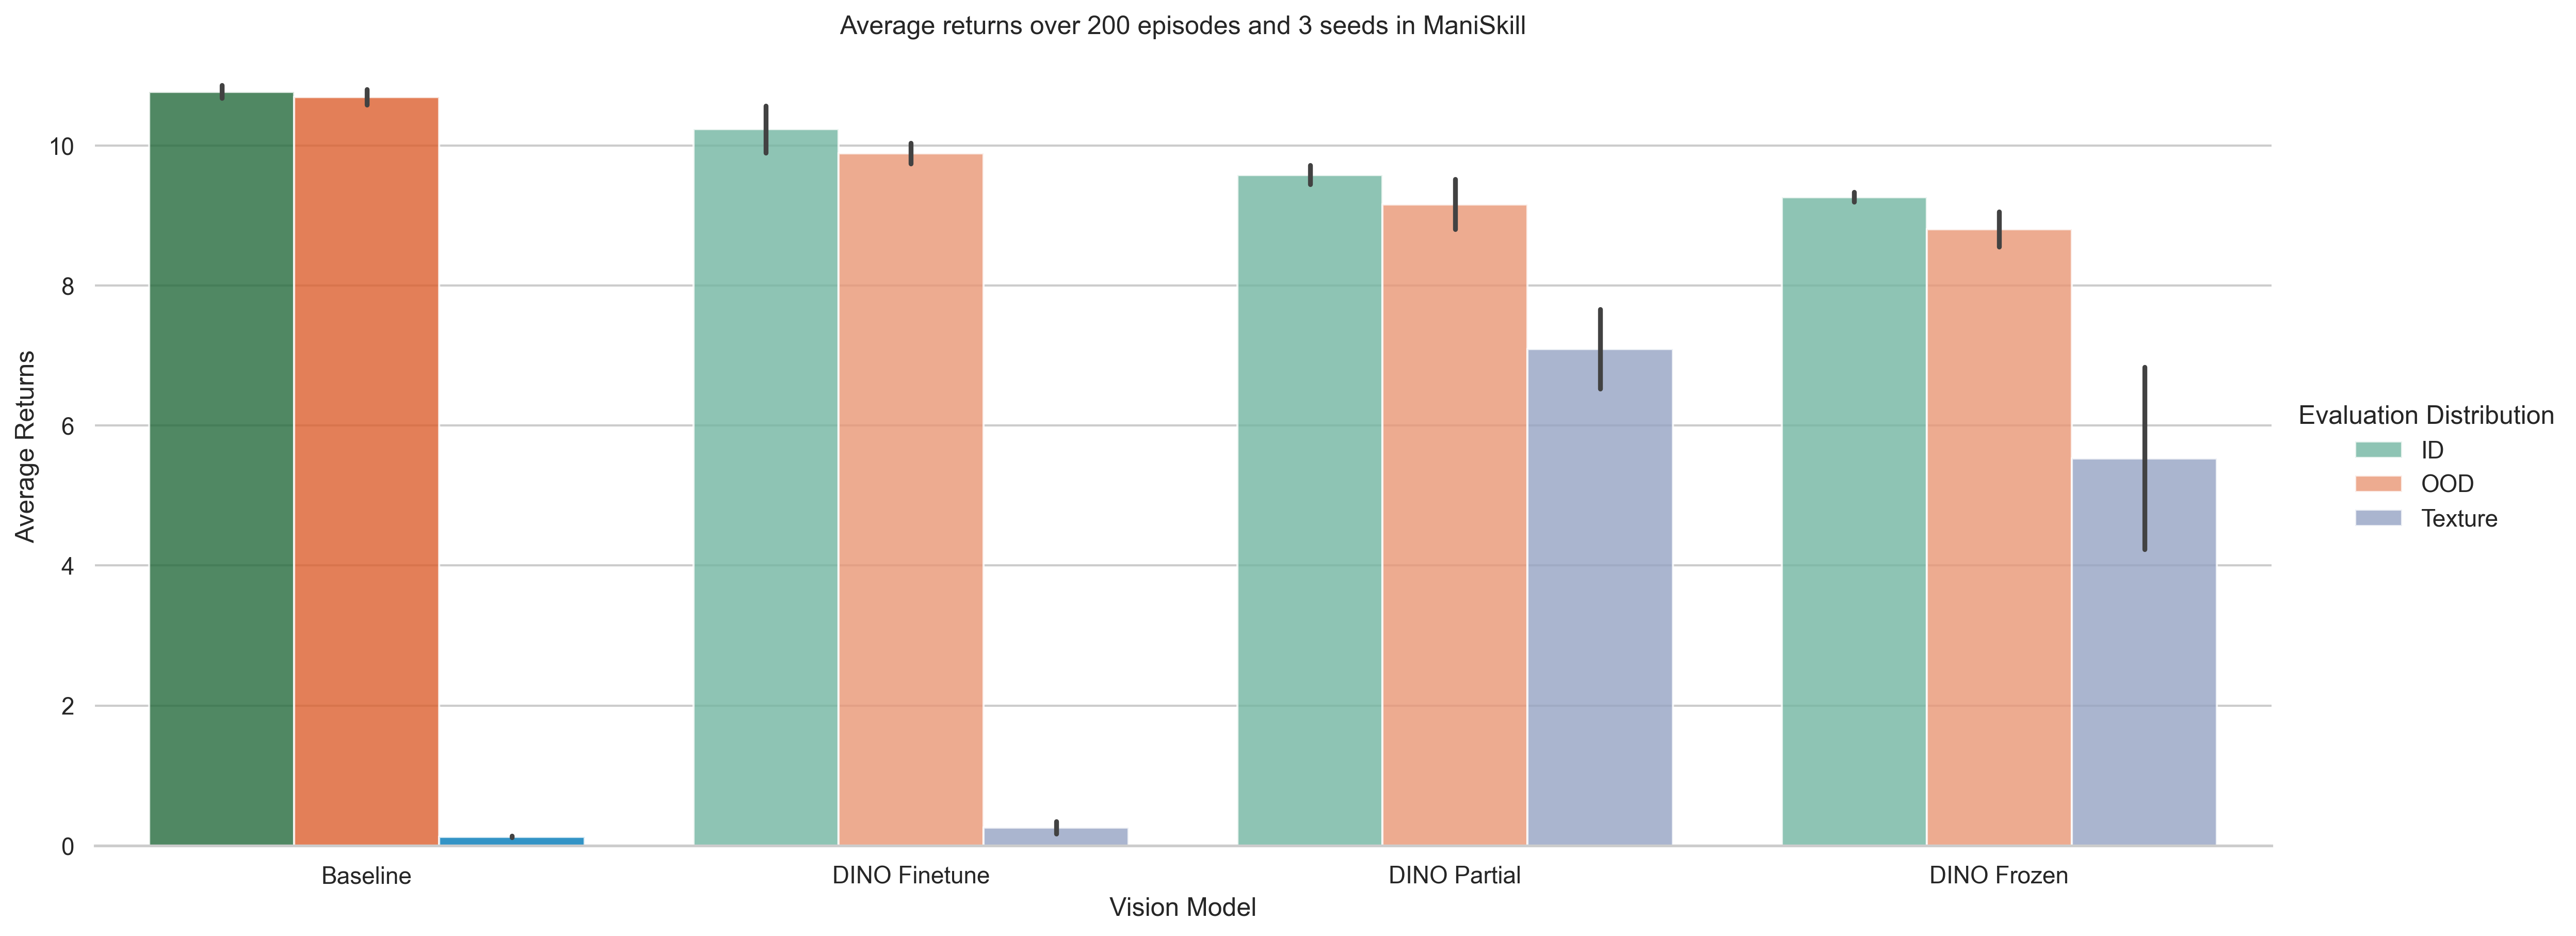

In [60]:
plot_maniskill(
    files_labels=[
        # ------- Baseline -------
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID/", "Baseline ID"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_1/", "Baseline ID"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_2/", "Baseline ID"),
        
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD/", "Baseline OOD"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_1/", "Baseline OOD"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_2/", "Baseline OOD"),

        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood/", "Baseline Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_1/", "Baseline Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_2/", "Baseline Texture"),

        # ------- DINO FT -------
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID/", "DINO Finetune ID"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_1/", "DINO Finetune ID"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_2/", "DINO Finetune ID"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD/", "DINO Finetune OOD"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_1/", "DINO Finetune OOD"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_2/", "DINO Finetune OOD"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood/", "DINO Finetune Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_1/", "DINO Finetune Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_2/", "DINO Finetune Texture"),

        # ------- DINO Partial -------
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID/", "DINO Partial ID"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_1/", "DINO Partial ID"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_2/", "DINO Partial ID"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial OOD"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_1/", "DINO Partial OOD"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_2/", "DINO Partial OOD"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood/", "DINO Partial Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_1/", "DINO Partial Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_2/", "DINO Partial Texture"),

        # ------- DINO Frozen -------
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID/", "DINO Frozen ID"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_1/", "DINO Frozen ID"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_2/", "DINO Frozen ID"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD/", "DINO Frozen OOD"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_1/", "DINO Frozen OOD"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_2/", "DINO Frozen OOD"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood/", "DINO Frozen Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_1/", "DINO Frozen Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_2/", "DINO Frozen Texture"),
    ]
)

[{'reward': 377.29902971240693, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 410.9974950517714, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 299.884087347748, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 62.02624958534027, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 41.71867405593395, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 70.5092355363071, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 38.336922818725, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 21.271455326806755, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 70.43066598370672, 'model': 'Baseline', 'Evaluation Distribution': 'Weak'}, {'reward': 18.422632095249572, 'model': 'Baseline', 'Evaluation Distribution': 'Strong'}, {'reward': 12.629755065776408, 'model': 'Baseline', 'Evaluation Distribution': 'Strong'}, {'rew

<Figure size 6000x1800 with 0 Axes>

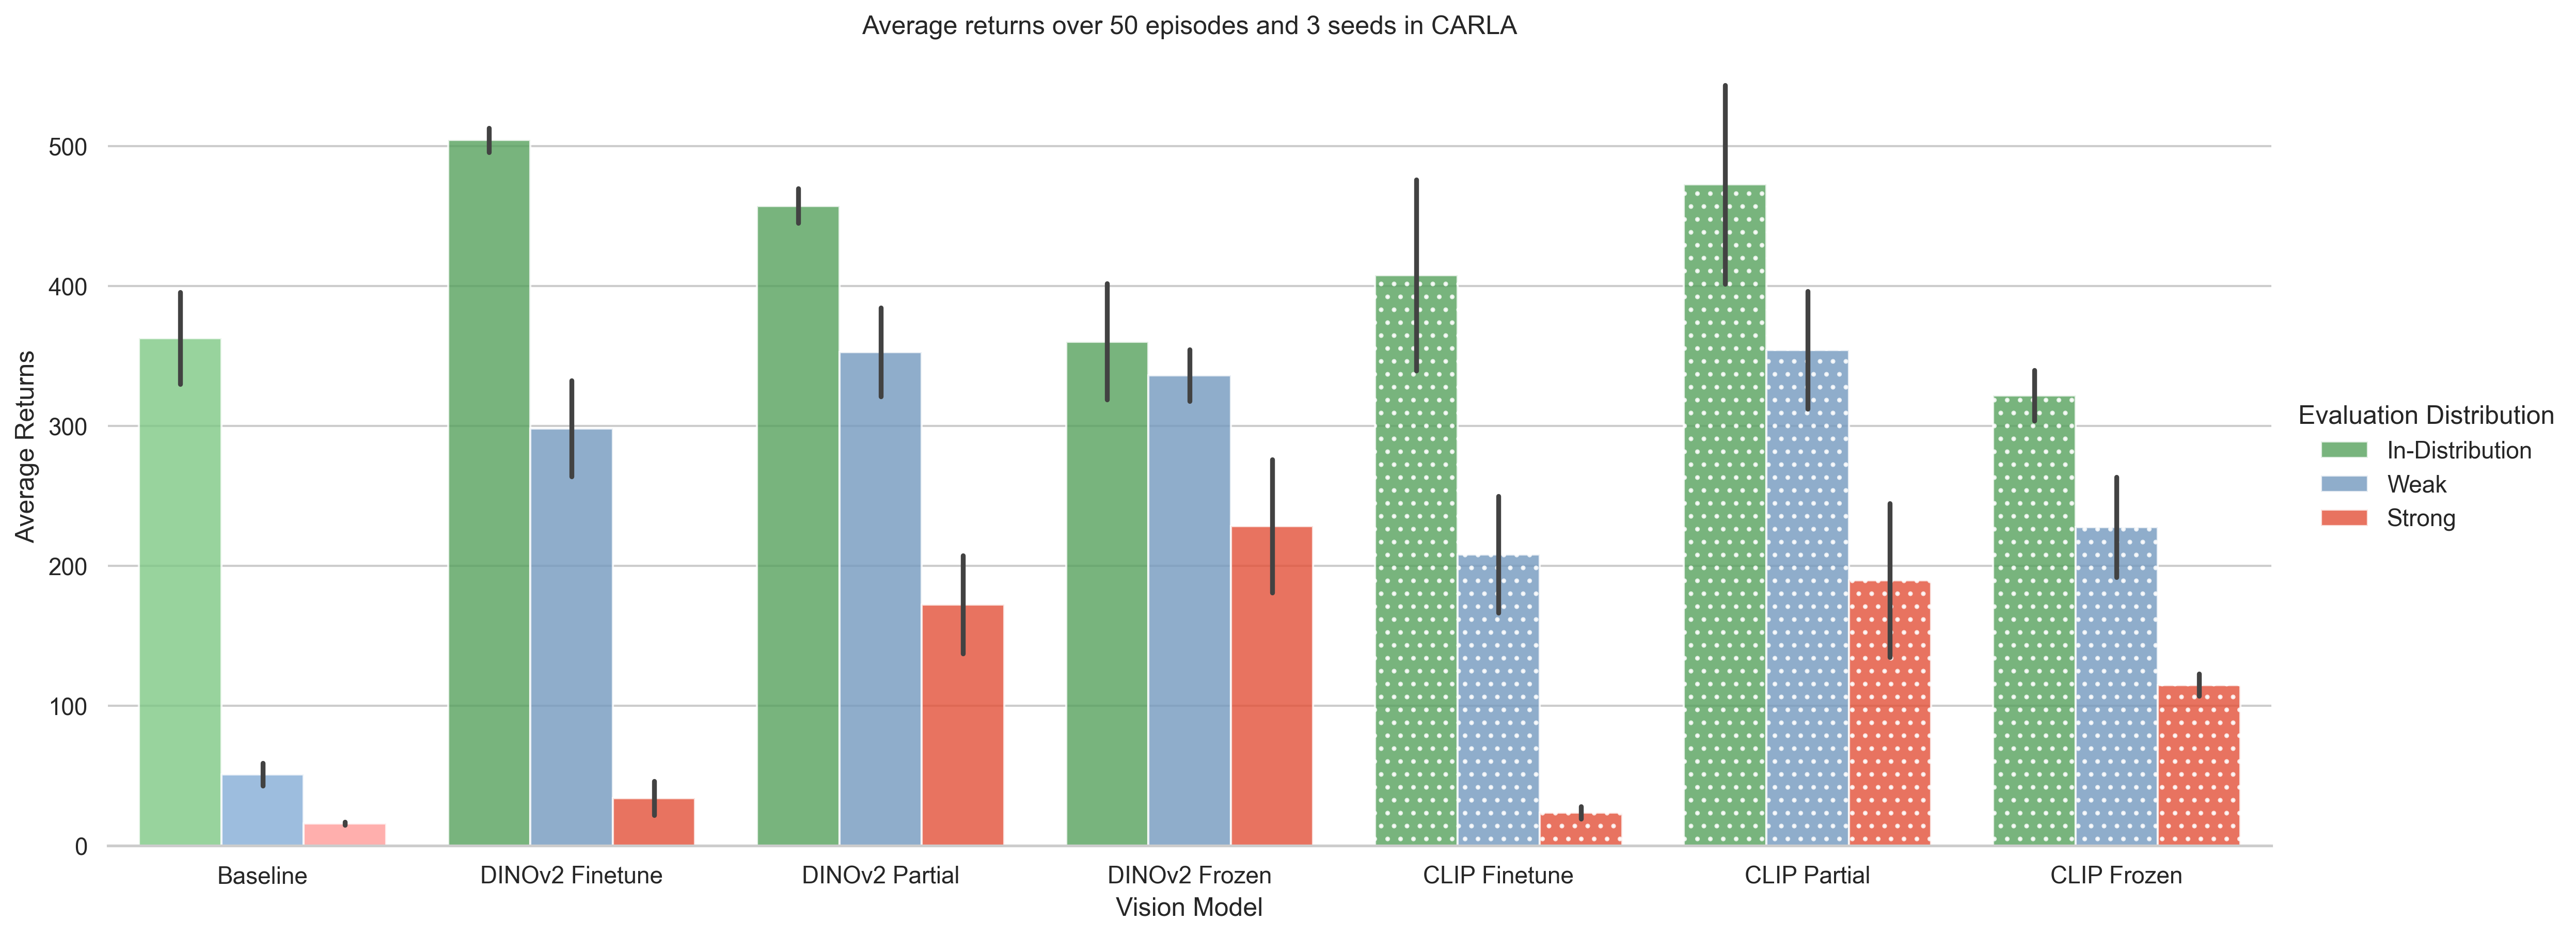

In [58]:
plot_carla(
    files_labels=[
        # ------- Baseline -------
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_1", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_2", "Baseline In-Distribution"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light", "Baseline Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_1", "Baseline Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_2", "Baseline Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light", "Baseline Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_1", "Baseline Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_2", "Baseline Weak"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light", "Baseline Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_1", "Baseline Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_2", "Baseline Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light", "Baseline Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_1", "Baseline Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_2", "Baseline Strong"),

        # ------- DINO FT -------
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_1", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_2", "DINOv2 Finetune In-Distribution"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light", "DINOv2 Finetune Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_1", "DINOv2 Finetune Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_2", "DINOv2 Finetune Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light", "DINOv2 Finetune Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_1", "DINOv2 Finetune Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_2", "DINOv2 Finetune Weak"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light", "DINOv2 Finetune Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_1", "DINOv2 Finetune Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_2", "DINOv2 Finetune Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light", "DINOv2 Finetune Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_1", "DINOv2 Finetune Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_2", "DINOv2 Finetune Strong"),
        
        # ------- DINOv2 Partial -------
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_1", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_2", "DINOv2 Partial In-Distribution"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light", "DINOv2 Partial Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_1", "DINOv2 Partial Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_2", "DINOv2 Partial Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light", "DINOv2 Partial Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINOv2 Partial Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINOv2 Partial Weak"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light", "DINOv2 Partial Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_1", "DINOv2 Partial Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_2", "DINOv2 Partial Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light", "DINOv2 Partial Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINOv2 Partial Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINOv2 Partial Strong"),

        # ------- DINOv2 Frozen -------
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_1", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_2", "DINOv2 Frozen In-Distribution"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light", "DINOv2 Frozen Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINOv2 Frozen Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINOv2 Frozen Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light", "DINOv2 Frozen Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_1", "DINOv2 Frozen Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_2", "DINOv2 Frozen Weak"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light", "DINOv2 Frozen Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINOv2 Frozen Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINOv2 Frozen Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light", "DINOv2 Frozen Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_1", "DINOv2 Frozen Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_2", "DINOv2 Frozen Strong"),

        # ------- CLIP FT -------
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_1", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_2", "CLIP Finetune In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP Finetune Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP Finetune Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP Finetune Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light", "CLIP Finetune Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_1", "CLIP Finetune Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_2", "CLIP Finetune Weak"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP Finetune Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP Finetune Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP Finetune Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light", "CLIP Finetune Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_1", "CLIP Finetune Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_2", "CLIP Finetune Strong"),

        # ------- CLIP Partial -------
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_1", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_2", "CLIP Partial In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP Partial Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_1", "CLIP Partial Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_2", "CLIP Partial Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light", "CLIP Partial Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_1", "CLIP Partial Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_2", "CLIP Partial Weak"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP Partial Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_1", "CLIP Partial Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_2", "CLIP Partial Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light", "CLIP Partial Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_1", "CLIP Partial Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_2", "CLIP Partial Strong"),

        # ------- CLIP Frozen -------
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_1", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_2", "CLIP Frozen In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP Frozen Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP Frozen Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP Frozen Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light", "CLIP Frozen Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP Frozen Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP Frozen Weak"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP Frozen Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP Frozen Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP Frozen Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light", "CLIP Frozen Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP Frozen Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP Frozen Strong"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_56744/4048927896.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

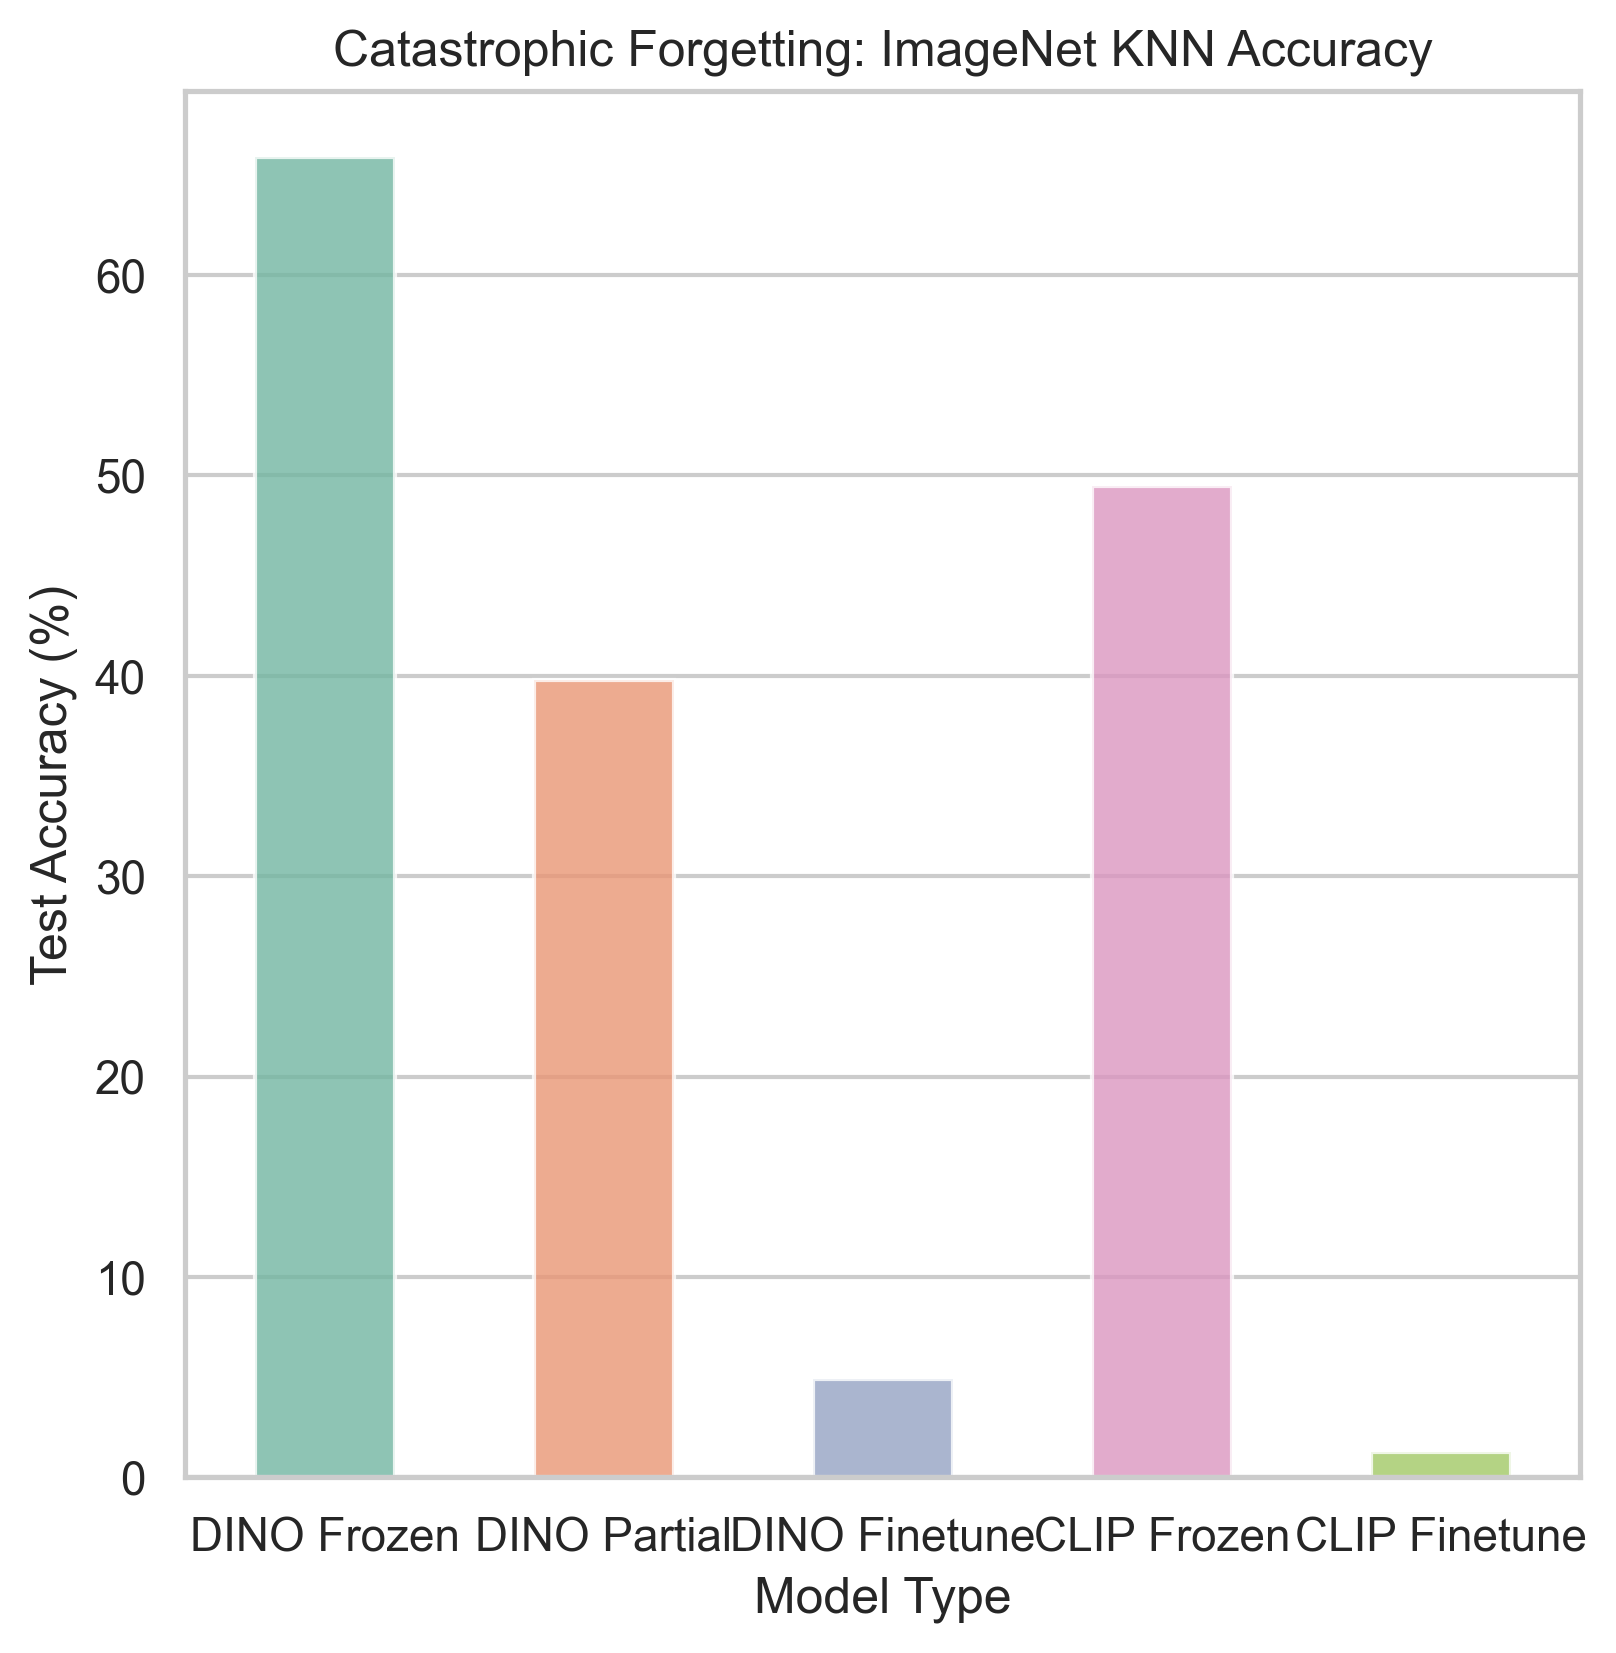

In [3]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92, 49.45, 1.27]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)

## Jaccard Index
With maniskill vision models

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_56744/2129095480.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=jaccard_index, x=labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Segmentation abiltity: Jaccard Index'}, xlabel='Model Type', ylabel='Jaccard Index(%)'>

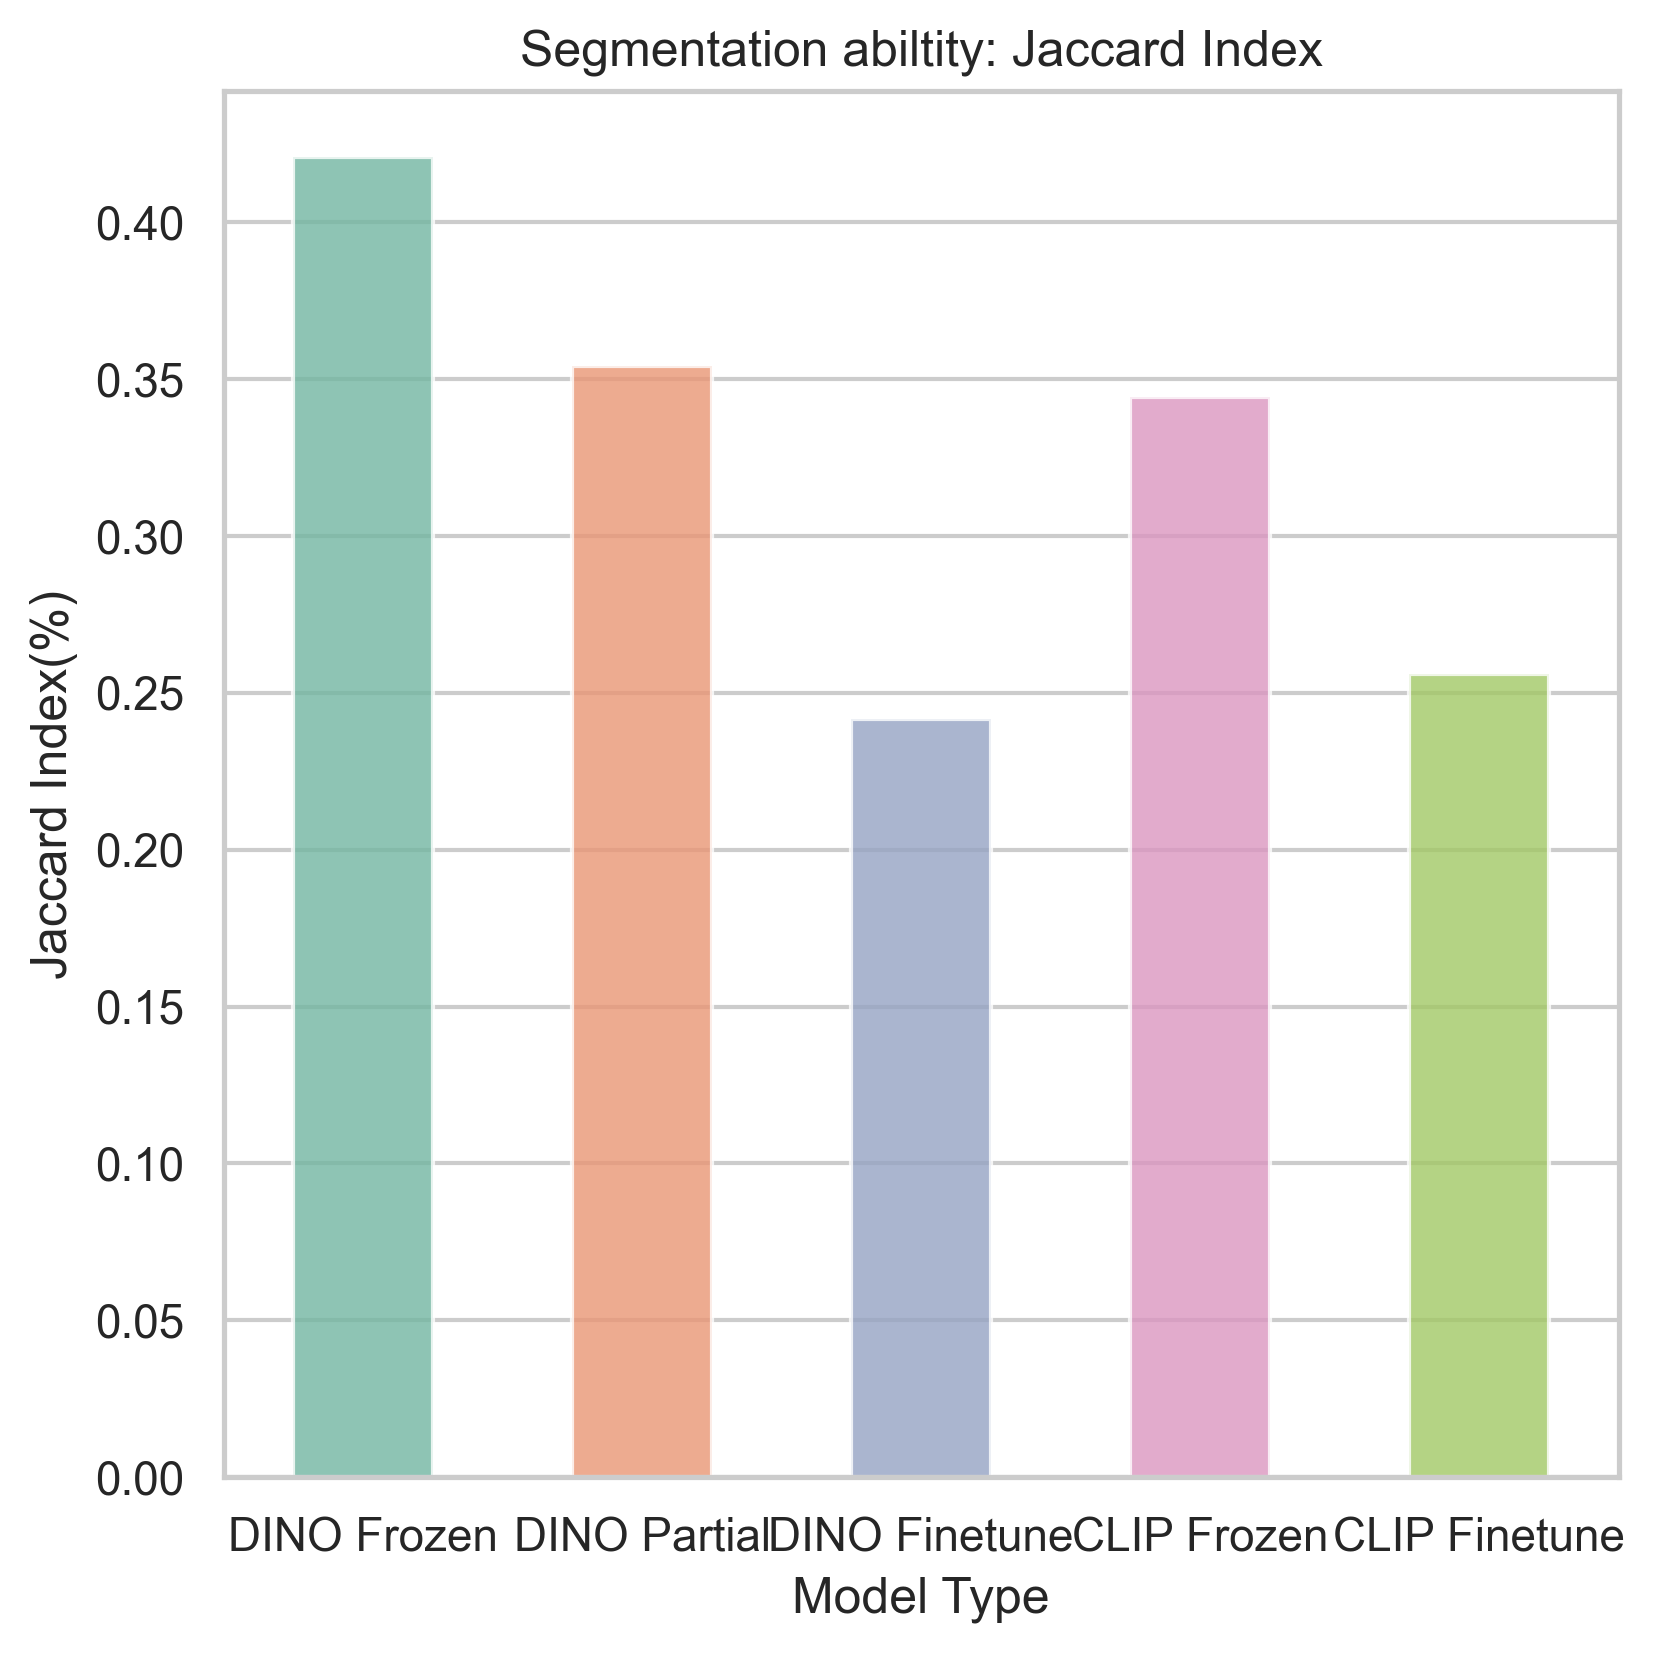

In [4]:
jaccard_index = [0.42062002258921743, 0.35423243885115097, 0.2416849635988227, 0.3443435035712217, 0.25605167583198163]
labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Jaccard Index(%)")
plt.title(f"Segmentation abiltity: Jaccard Index")
sns.barplot(y=jaccard_index, x=labels, palette="Set2", width=0.5, alpha=0.8)